In [39]:
from parameters import RewNames, UnrewNamesSub, OUTDATA_PATH, LEAVE as leave, DRINK as drink, EXPLORE as explore
from MM_Traj_Utils import NewMaze, LoadTraj, LoadTrajFromPath, SplitModeClips, NewNodes4
import numpy as np
import pickle
from MM_Models import ModeMask

In [3]:
import matplotlib.pyplot as plt

In [4]:
ma = NewMaze(6)

In [45]:
# Mode analysis for all animals
Names=RewNames+UnrewNamesSub
k=len(RewNames)
for i,nickname in enumerate(Names):
    tf=LoadTrajFromPath(OUTDATA_PATH + nickname+'-tf')
    cl=SplitModeClips(tf,ma,re=i<k) # find the clips; no drink mode for unrewarded animals

    ti=np.array([tf.no[c[0]][c[1]+c[2],1]-tf.no[c[0]][c[1],1] for c in cl]) # duration in frames of each clip
    nn=np.array([np.sum(cl[np.where(cl[:,3]==leave)][:,2]),
                 np.sum(cl[np.where(cl[:,3]==drink)][:,2]),
                 np.sum(cl[np.where(cl[:,3]==explore)][:,2])]) # number of node steps in each mode
    nf=np.array([np.sum(ti[np.where(cl[:,3]==leave)]),
                 np.sum(ti[np.where(cl[:,3]==drink)]),
                 np.sum(ti[np.where(cl[:,3]==explore)])]) # number of frames in each mode
    tr=np.zeros((3,3)) # number of transitions between the 3 modes
    for i in range(1,len(cl)):
        tr[cl[i-1,3],cl[i,3]]+=1
    ce=cl[np.where(cl[:,3]==explore)] # clips of exploration
    ne=np.concatenate([tf.no[c[0]][c[1]:c[1]+c[2],0] for c in ce]) # nodes excluding the last state in each clip
    le=6 # end nodes only
    ln=list(range(2**le-1,2**(le+1)-1)) # list of node numbers in level le
    ns=ne[np.isin(ne,ln)] # restricted to desired nodes
    wcn=NewNodes4(ns,nf[2]/len(ns)) # compute new nodes vs all nodes for exploration mode only
    with open(OUTDATA_PATH+nickname+'-Modes1', 'wb') as f: # save in one file per animal
        pickle.dump((nn,nf,tr,wcn),f)

Occupancy and transitions between modes

In [46]:
# Combine all the mode statistics from all animals into arrays
Names=RewNames+UnrewNamesSub
k=len(RewNames)
a=len(Names)
nn=np.zeros((a,3)) # number of nodes in each mode
nf=np.zeros((a,3)) # number of frames in each mode
tr=np.zeros((a,3,3)) # number of transitions between modes
ff=np.zeros((a,3)) # fraction of frames in each mode
wcn=[] # these arrays have different shape
for i,nickname in enumerate(Names):
    with open(OUTDATA_PATH+nickname+'-Modes1', 'rb') as f:
        nn1,nf1,tr1,wcn1=pickle.load(f)
    nn[i]=nn1
    nf[i]=nf1
    tr[i]=tr1
    wcn+=[wcn1]
    s=sum(nf[i])
    ff[i]=nf[i]/s

In [47]:
# List fraction of time in each mode
print('Fraction of frames in each mode')
print('     home | drink | explore')
print('rewarded:')
for i in range(k):
    print(Names[i]+': {:4.3f} | {:4.3f} | {:4.3f}'.format(*ff[i]))
print('------------------------')
print('Av: {:4.3f} | {:4.3f} | {:4.3f}'.format(*np.mean(ff[:k],axis=0)))
print('SD: {:4.3f} | {:4.3f} | {:4.3f}'.format(*np.std(ff[:k],axis=0)))
print('\nunrewarded:')
for i in range(k,len(Names)):
    print(Names[i]+': {:4.3f} | {:4.3f} | {:4.3f}'.format(*ff[i]))
print('------------------------')
print('Av: {:4.3f} | {:4.3f} | {:4.3f}'.format(*np.mean(ff[k:],axis=0)))
print('SD: {:4.3f} | {:4.3f} | {:4.3f}'.format(*np.std(ff[k:],axis=0)))

Fraction of frames in each mode
     home | drink | explore
rewarded:
B1: 0.052 | 0.113 | 0.835
B2: 0.057 | 0.154 | 0.789
B3: 0.052 | 0.071 | 0.877
B4: 0.057 | 0.076 | 0.867
C1: 0.050 | 0.098 | 0.852
C3: 0.086 | 0.100 | 0.814
C6: 0.063 | 0.139 | 0.798
C7: 0.040 | 0.083 | 0.877
C8: 0.038 | 0.085 | 0.877
C9: 0.031 | 0.113 | 0.857
------------------------
Av: 0.053 | 0.103 | 0.844
SD: 0.014 | 0.026 | 0.032

unrewarded:
B5: 0.065 | 0.000 | 0.935
B6: 0.057 | 0.000 | 0.943
B7: 0.068 | 0.000 | 0.932
D3: 0.063 | 0.000 | 0.937
D4: 0.063 | 0.000 | 0.937
D5: 0.052 | 0.000 | 0.948
D7: 0.026 | 0.000 | 0.974
D8: 0.038 | 0.000 | 0.962
D9: 0.042 | 0.000 | 0.958
------------------------
Av: 0.053 | 0.000 | 0.947
SD: 0.014 | 0.000 | 0.014


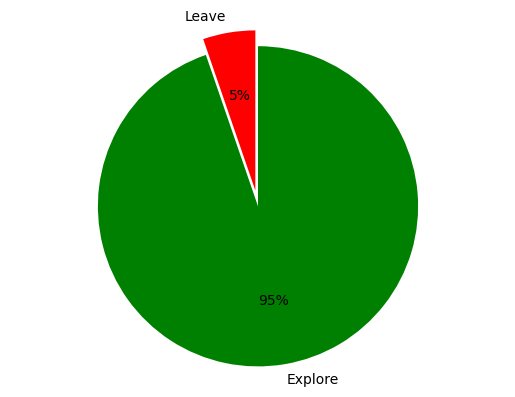

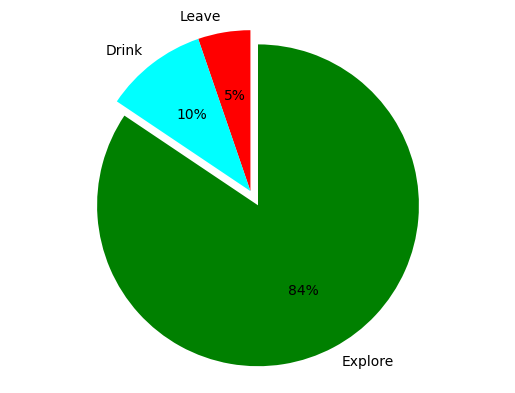

In [48]:
# Pie charts, where the slices will be ordered and plotted counter-clockwise:
labels = 'Leave','Explore'
av=np.mean(ff[k:],axis=0)
sizes = [av[0],av[2]]
explode = (0,0.1)  # only "explode" the 2nd slice
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=90,colors=['red','green'])
# ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
#         shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.savefig('figs/UnrewPie.pdf')
plt.show()

labels = 'Leave','Drink','Explore'
av=np.mean(ff[:k],axis=0)
sizes = [av[0],av[1],av[2]]
explode = (0,0,0.1)  # only "explode" the 2nd slice
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=False, startangle=90,colors=['red','cyan','green'])
# ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
#         shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.savefig('figs/RewPie.pdf')
plt.show()

In [50]:
# transitions between modes
print('Prob of transition between leave, drink, explore:')
print('     l->d  | l->e  | d->l  | d->e  | e->h  | e->d')
n=[]
for i,nickname in enumerate(RewNames):
    s=tr[i,0,1]+tr[i,0,2] # ignore the h->h transition
    nn=tr[i,0,1:]/s
    s=tr[i,1,0]+tr[i,1,2]
    nn=np.append(nn,[tr[i,1,0]/s,tr[i,1,2]/s])
    s=tr[i,2,0]+tr[i,2,1]
    nn=np.append(nn,[tr[i,2,0]/s,tr[i,2,1]/s])
    n+=[nn]
    print(nickname,': {:4.3f} | {:4.3f}'.format(nn[0],nn[1]),end='')
    print(' | {:4.3f} | {:4.3f}'.format(nn[2],nn[3]),end='')
    print(' | {:4.3f} | {:4.3f}'.format(nn[4],nn[5]))
n=np.array(n)
av=np.mean(n,axis=0)
sd=np.std(n,axis=0)
print('----------------------------------------------')
print('Av : {:4.3f} | {:4.3f} | {:4.3f} | {:4.3f} | {:4.3f} | {:4.3f}'.format(*av))
print('SD : {:4.3f} | {:4.3f} | {:4.3f} | {:4.3f} | {:4.3f} | {:4.3f}'.format(*sd))

Prob of transition between leave, drink, explore:
     l->d  | l->e  | d->l  | d->e  | e->h  | e->d
B1 : 0.561 | 0.439 | 0.119 | 0.881 | 0.319 | 0.681
B2 : 0.571 | 0.429 | 0.075 | 0.925 | 0.377 | 0.623
B3 : 0.172 | 0.828 | 0.025 | 0.975 | 0.605 | 0.395
B4 : 0.553 | 0.447 | 0.127 | 0.873 | 0.437 | 0.563
C1 : 0.663 | 0.337 | 0.199 | 0.801 | 0.366 | 0.634
C3 : 0.610 | 0.390 | 0.156 | 0.844 | 0.552 | 0.448
C6 : 0.507 | 0.493 | 0.107 | 0.893 | 0.354 | 0.646
C7 : 0.325 | 0.675 | 0.058 | 0.942 | 0.324 | 0.676
C8 : 0.584 | 0.416 | 0.086 | 0.914 | 0.426 | 0.574
C9 : 0.557 | 0.443 | 0.060 | 0.940 | 0.230 | 0.770
----------------------------------------------
Av : 0.510 | 0.490 | 0.101 | 0.899 | 0.399 | 0.601
SD : 0.141 | 0.141 | 0.049 | 0.049 | 0.106 | 0.106


In [54]:
# markdown table of transition probabilities
print('|from / to:   | leave | drink | explore |')
print('|:--|:-:|:-:|:-:|')
print('|**leave**|   |{:3.2f} ± {:3.2f}|{:3.2f} ± {:3.2f}|'.format(av[0],sd[0],av[1],sd[1]))
print('|**drink**|{:3.2f} ± {:3.2f}|  |{:3.2f} ± {:3.2f}|'.format(av[2],sd[2],av[3],sd[3]))
print('|**explore**|{:3.2f} ± {:3.2f}|{:3.2f} ± {:3.2f}|   |'.format(av[4],sd[4],av[5],sd[5]))

|from / to:   | leave | drink | explore |
|:--|:-:|:-:|:-:|
|**leave**|   |0.51 ± 0.14|0.49 ± 0.14|
|**drink**|0.10 ± 0.05|  |0.90 ± 0.05|
|**explore**|0.40 ± 0.11|0.60 ± 0.11|   |
